# Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones

Autores: Matías Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing, impute, neighbors, feature_extraction, pipeline
from sklearn.experimental import enable_iterative_imputer
from typing import List, Tuple


def plot_imputation_graph(imputations: Tuple[str, List[pd.DataFrame]],
                          missing_cols: List[str]) -> None:
    _, axs = plt.subplots(len(missing_cols), figsize=(10, 10))
    for ax, col_name in zip(axs, missing_cols):
        data = pd.concat([
            imputation_df[[col_name]].assign(method=method)
            for method, imputation_df in imputations
        ])
        seaborn.kdeplot(data=data, x=col_name, hue="method", ax=ax)


def impute_by(values, missing_col_names, estimator):
    indicator = impute.MissingIndicator()
    indicator.fit_transform(values)

    imputer = impute.IterativeImputer(
        random_state=0, estimator=estimator)
    imputed_values = imputer.fit_transform(values)
    imputed_df = pd.DataFrame(imputed_values[:, indicator.features_],
                              columns=missing_col_names)
    return imputed_df

In [2]:
URL_MELB_HOUSING_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_housing_filtered_df.csv"
URL_MELB_SUBURB_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_suburb_filtered_df.csv"

melb_housing_df = pd.read_csv(URL_MELB_HOUSING_FILTERED)
melb_suburb_df = pd.read_csv(URL_MELB_SUBURB_FILTERED)
melb_combined_df = melb_housing_df.join(melb_suburb_df, on="suburb_id")
melb_combined_df

,housing_price,housing_room_segment,housing_bathroom_segment,housing_land_size,housing_building_area,housing_type,housing_year_built,suburb_id,suburb_name,suburb_region_segment,suburb_council_area,suburb_rental_dailyprice
0,1480000.0,"(1, 2]","(0, 1]",202.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
1,1035000.0,"(1, 2]","(0, 1]",156.0,79.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
2,1465000.0,"(2, 3]","(1, 2]",134.0,150.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
3,850000.0,"(2, 3]","(1, 2]",94.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
4,1600000.0,"(3, 4]","(0, 1]",120.0,142.0,h,2014.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
...,...,...,...,...,...,...,...,...,...,...,...,...
13201,1245000.0,"(3, 4]","(1, 2]",652.0,NaN,h,1981.0,248,Wheelers Hill,South-Eastern Metropolitan,['Monash'],109.742268
13202,1031000.0,"(2, 3]","(1, 2]",333.0,133.0,h,1995.0,104,Williamstown,Western Metropolitan,['Hobsons Bay'],177.911765
13203,1170000.0,"(2, 3]","(1, 2]",436.0,NaN,h,1997.0,104,Williamstown,Western Metropolitan,['Hobsons Bay'],177.911765
13204,2500000.0,"(3, 4]","(0, 1]",866.0,157.0,h,1920.0,104,Williamstown,Western Metropolitan,['Hobsons Bay'],177.911765


## Enconding 

### Dict Vectorizer

In [3]:
categorical_cols = [
    "housing_room_segment", "housing_bathroom_segment", "housing_type",
    "suburb_region_segment"
]
numerical_cols = [
    "housing_price", "housing_land_size", "suburb_rental_dailyprice"
]
feature_cols = categorical_cols + numerical_cols
features = list(melb_combined_df[feature_cols].T.to_dict().values())

vectorizer = feature_extraction.DictVectorizer()
feature_matrix = vectorizer.fit_transform(features)
feature_matrix

<13206x20 sparse matrix of type '<class 'numpy.float64'>'
	with 92442 stored elements in Compressed Sparse Row format>

In [4]:
vectorizer.get_feature_names()

['housing_bathroom_segment=(0, 1]',
 'housing_bathroom_segment=(1, 2]',
 'housing_bathroom_segment=(2, 8]',
 'housing_land_size',
 'housing_price',
 'housing_room_segment=(0, 1]',
 'housing_room_segment=(1, 2]',
 'housing_room_segment=(2, 3]',
 'housing_room_segment=(3, 4]',
 'housing_room_segment=(4, 10]',
 'housing_type=h',
 'housing_type=t',
 'housing_type=u',
 'suburb_region_segment=Eastern Metropolitan',
 'suburb_region_segment=Northern Metropolitan',
 'suburb_region_segment=South-Eastern Metropolitan',
 'suburb_region_segment=Southern Metropolitan',
 'suburb_region_segment=Victoria',
 'suburb_region_segment=Western Metropolitan',
 'suburb_rental_dailyprice']

### One-Hot Encoding

In [5]:
ohe = preprocessing.OneHotEncoder(sparse=False)
feature_matrix_ohe = np.hstack([
    ohe.fit_transform(melb_combined_df[categorical_cols]),
    melb_combined_df[numerical_cols]
])
feature_matrix_ohe.shape

(13206, 20)

## Imputación por KNN

### Sin escalado

In [6]:
missing_cols = ["housing_year_built", "housing_building_area"]
estimator = neighbors.KNeighborsRegressor(n_neighbors=2)

In [7]:
missing_df = melb_combined_df[missing_cols]
original_df = missing_df.dropna()
all_df = np.hstack([missing_df, feature_matrix.todense()])

knn_missing_cols = impute_by(missing_df, missing_cols, estimator)
knn_all_cols = impute_by(all_df, missing_cols, estimator)

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


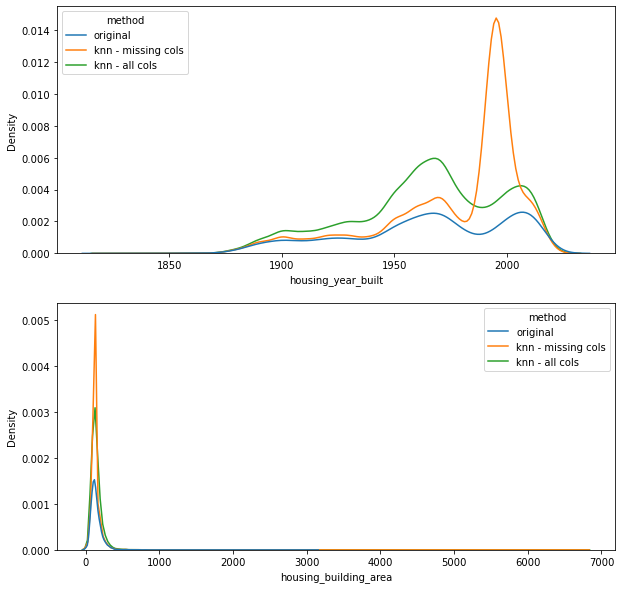

In [8]:
imputations = [
    ("original", original_df),
    ("knn - missing cols", knn_missing_cols),
    ("knn - all cols", knn_all_cols)
]
plot_imputation_graph(imputations, missing_cols)

### Con escalado

In [ ]:
scaler = preprocessing.StandardScaler()
original_scaled_df = pd.DataFrame(scaler.fit_transform(original_df),
                                  columns=missing_cols)
knn_scaled_missing_cols = impute_by(scaler.fit_transform(missing_df),
                                    missing_cols, estimator)
knn_scaled_all_cols = impute_by(scaler.fit_transform(all_df), missing_cols,
                                estimator)

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [ ]:
imputations = [
    ("scaled original", original_scaled_df),
    ("knn - scaled missing cols", knn_scaled_missing_cols),
    ("knn - scaled all cols", knn_scaled_all_cols)
]
plot_imputation_graph(imputations, missing_cols)

### Selección de imputación por todas las columnas

In [ ]:
feature_matrix = np.hstack([feature_matrix.todense(), knn_all_cols])

## Reducción de dimensionalidad

## Composición del resultado